# Simulate Thompson Sampling

Evaluation Metrics: 

(1)ROC_AUC_SCORE: calculated between true labels and predictions for each iterations  
(2)Cumulative gain: for each iteration, if the maximum prediction corresponding with the valid labels gain 1, otherwise 0. Show cumulative gain for all iterations.

There are two settings for labelling:  
(a). repeated labelling: allow one instance to be labelled more than once   
(b). unrepeated labelling: otherwise

Two settings for recommendation:  
(I). Random Sampling (RS)  
(II). Thompson Sampling (TS)


I used [NATIONS](https://github.com/dongwookim-ml/kg-data) dataset as an example, there are totally 2,024 valid triples. For (b), it doesn't make sense if we sample more than 2,024 times. So I chose test 2,000 iterations for (b). And more iterations (5000) for repeated labelling.

Experiment 1: unrepeated labelling + 2000 iterations 

Experiment 2: repeated labelling + 5000 iterations


In [2]:
# direct to parent folder
import sys
sys.path.append("..")

from acton.database import LabelOnlyASCIIReader, LabelOnlyManagedHDF5Database
from acton.predictors import TensorPredictor
from acton.recommenders import ThompsonSamplingRecommender
from acton.labellers import LabelOnlyDatabaseLabeller
import acton.acton
import tempfile
import astropy.io.ascii as io_ascii
import os.path
import numpy
import logging
import matplotlib.pyplot as plt
import pickle

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
logging.basicConfig(level = logging.DEBUG)

_path = '../tests/kg-data/nation/triples.txt'
output_path = '../acton/acton.proto'
n_dim = 10
TS= 0.0
RANDOM = 1.0

In [ ]:
with LabelOnlyASCIIReader(_path, n_dim) as reader:
    n_relations = reader.n_relations
    n_entities = reader.n_entities
    totoal_size = n_relations * n_entities * n_entities
    ids = numpy.arange(totoal_size)
    
   # repeated labelling
    N_EPOCHS = 5000
    repeated_labelling = True

    results = {}

    # TS
    results['TS_repeated_train_error_list'],
    results['TS_repeated_test_error_list'],
    results['TS_repeated_gain'] =  \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='LabelOnlyDatabaseLabeller',
            diversity=TS,
            repeated_labelling=repeated_labelling
    )
    # Random
    results['RD_repeated_train_error_list'],
    results['RD_repeated_test_error_list'],
    results['RD_repeated_gain'] =  \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='LabelOnlyDatabaseLabeller',
            diversity=RANDOM,
            repeated_labelling=repeated_labelling)

    # unrepeated labelling
    N_EPOCHS = 2000
    repeated_labelling = False

    # TS
    results['TS_unrepeated_train_error_list'],
    results['TS_unrepeated_test_error_list'],
    results['TS_unrepeated_gain'] = \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='LabelOnlyDatabaseLabeller',
            diversity=TS,
            repeated_labelling=repeated_labelling)

    # Random
    results['RD_unrepeated_train_error_list'],
    results['RD_unrepeated_test_error_list'],
    results['RD_unrepeated_gain'] = \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='LabelOnlyDatabaseLabeller',
            diversity=RANDOM,
            repeated_labelling=repeated_labelling)


In [4]:
with open('outfile', 'wb') as fp:
    pickle.dump(results,fp)

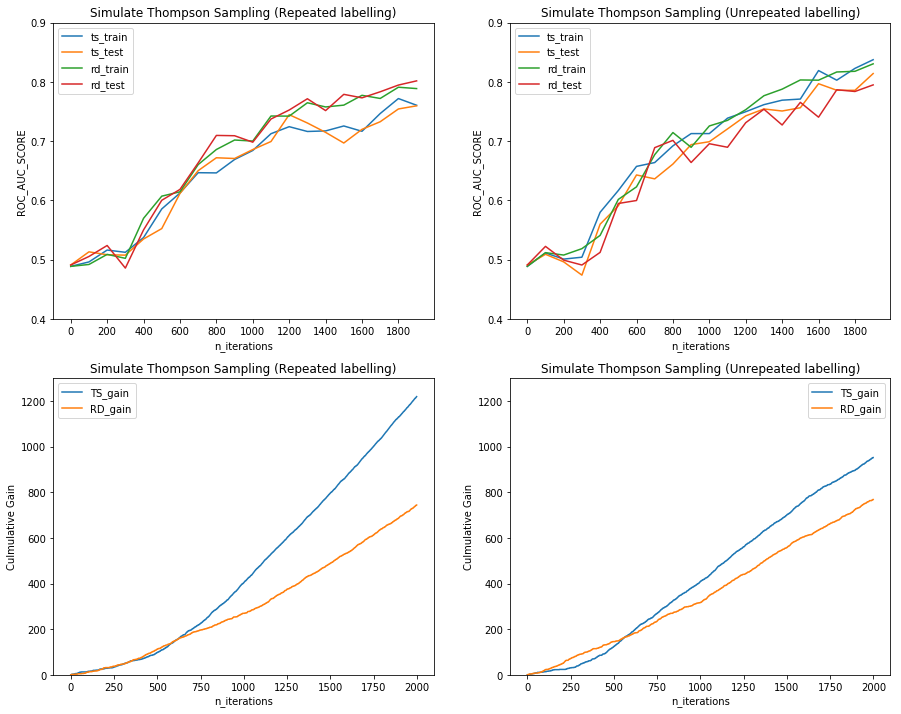

In [25]:
#with open ('outfile', 'rb') as fp:
#    results = pickle.load(fp)

plt.figure(figsize= (15,12))

# only plot 2000 iterations for the purpose of comparison with unrepeated labelling
plt.subplot(221)
plt.plot(results['TS_repeated_train_error_list'][:2000][::100], label = 'ts_train')
plt.plot(results['TS_repeated_test_error_list'][:2000][::100], label = 'ts_test')
plt.plot(results['RD_repeated_train_error_list'][:2000][::100], label = 'rd_train')
plt.plot(results['RD_repeated_test_error_list'][:2000][::100], label = 'rd_test')
plt.xticks(numpy.arange(20, step = 2), numpy.arange(2000)[::200])
plt.xlabel('n_iterations')
plt.ylabel('ROC_AUC_SCORE')
plt.ylim(0.4,0.9)
plt.title('Simulate Thompson Sampling (Repeated labelling)')
plt.legend()

plt.subplot(222)
plt.plot(results['TS_unrepeated_train_error_list'][::100], label = 'ts_train')
plt.plot(results['TS_unrepeated_test_error_list'][::100], label = 'ts_test')
plt.plot(results['RD_unrepeated_train_error_list'][::100], label = 'rd_train')
plt.plot(results['RD_unrepeated_test_error_list'][::100], label = 'rd_test')
plt.xticks(numpy.arange(20, step = 2), numpy.arange(2000)[::200])
plt.xlabel('n_iterations')
plt.ylabel('ROC_AUC_SCORE')
plt.ylim(0.4,0.9)
plt.title('Simulate Thompson Sampling (Unrepeated labelling)')
plt.legend()

plt.subplot(223)
plt.plot(numpy.cumsum(results['TS_repeated_gain'][:2000]), label = 'TS_gain')
plt.plot(numpy.cumsum(results['RD_repeated_gain'][:2000]), label = 'RD_gain')
plt.ylabel('Culmulative Gain')
plt.xlabel('n_iterations')
plt.ylim(0,1300)
plt.title('Simulate Thompson Sampling (Repeated labelling)')
plt.legend()

plt.subplot(224)
plt.plot(numpy.cumsum(results['TS_unrepeated_gain']), label = 'TS_gain')
plt.plot(numpy.cumsum(results['RD_unrepeated_gain']), label = 'RD_gain')
plt.ylabel('Culmulative Gain')
plt.xlabel('n_iterations')
plt.ylim(0,1300)
plt.title('Simulate Thompson Sampling (Unrepeated labelling)')
plt.legend()
plt.savefig('comparison.png')

Woo looks interesting. Now, let's analyse it:

Cumulative Gain:

For both repeated and unrepeated labelling, Thompson sampling has bigger cumulative gain. That's the point of Thompson sampling, finding the valid triples (minimise the cumulate regret/ maximise the cumulative gain) by sequentially updating posteriers. 

Random sampling performs similar in terms of two labelling approaches. Thompson sampling has bigger gain for repeated labelling, the reason is that thompson sampling can pick repeated valid triples with great certainty rather than guessing new candidates. 

ROC_AUC_SCORE:

Again, the random sampling has similar performance in terms of repeated labelling and unrepeated labelling. But thompson sampling clearly performs worse with repeated labelling setting. I guess it because that Thompson sampling tends to recommend more repeated triples than random sampling. Although these repeated triples could be valid in high possibility (Thompson sampling gets higher cumulative gains), the less variety may also leads to poor prediction in terms of all entires (since ROC_AUC_SCORE reflects the ranking quality).

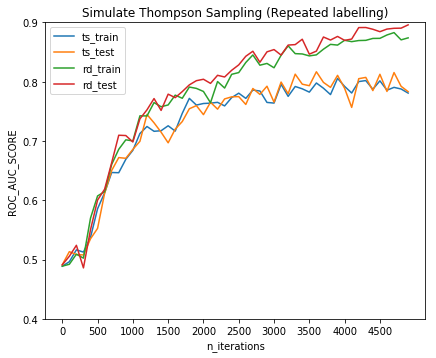

In [5]:
with open ('outfile', 'rb') as fp:
    results = pickle.load(fp)
plt.figure(figsize= (15,12))
    
# plot 5000 iterations
plt.subplot(221)
plt.plot(results['TS_repeated_train_error_list'][::100], label = 'ts_train')
plt.plot(results['TS_repeated_test_error_list'][::100], label = 'ts_test')
plt.plot(results['RD_repeated_train_error_list'][::100], label = 'rd_train')
plt.plot(results['RD_repeated_test_error_list'][::100], label = 'rd_test')
plt.xticks(numpy.arange(50, step = 5), numpy.arange(5000)[::500])
plt.xlabel('n_iterations')
plt.ylabel('ROC_AUC_SCORE')
plt.ylim(0.4,0.9)
plt.title('Simulate Thompson Sampling (Repeated labelling)')
plt.legend()